In [16]:
# COLLAPSED
import torch
from nerfstudio.cameras.cameras import Cameras, CameraType
from nerfstudio.utils import plotly_utils as vis

cx = 20
cy = 10
fx = 20
fy = 20

c2w = torch.eye(4)[None, :3, :]

camera = Cameras(fx=fx, fy=fy, cx=cx, cy=cy, camera_to_worlds=c2w, camera_type=CameraType.PANORAMA)
fig = vis.vis_camera_rays(camera)
fig.show()

print(camera.image_width, " ", camera.image_height)

tensor([40])   tensor([20])


In [1]:
import numpy as np

x = np.linspace(0, 4, 20)
z1 = np.cos(x)

NameError: name 'linspace' is not defined

In [2]:
import numpy as np

a = np.array([[0], [0], [0], [1]], dtype=np.float32)
b = np.array([[0,0,0,1]], dtype=np.float32)

print(a.shape)
print(b.shape)

(4, 1)
(1, 4)


In [5]:
import torch

fx, fy = 20, 20
cx, cy = 20, 10

image_height = 20
image_width = 40

a = torch.tensor([1,2,3]).view(-1, 1, 1)
print(a.repeat(1,2,1).shape)

image_coords = torch.meshgrid(torch.arange(image_height), torch.arange(image_width), indexing="ij")
image_coords = torch.stack(image_coords, dim=-1) + 0.5  # stored as (y, x) coordinates

x = image_coords[..., 1]
y = image_coords[..., 0]

coord = torch.stack([(x - cx) / fx, -(y - cy) / fy], -1)
coord_x_offset = torch.stack([(x - cx + 1) / fx, -(y - cy) / fy], -1)
coord_y_offset = torch.stack([(x - cx) / fx, -(y - cy + 1) / fy], -1)

coord_stack_old = torch.stack([coord, coord_x_offset, coord_y_offset], dim=0)

# Get our image coordinates and image coordinates offset by 1 (offsets used for dx, dy calculations)
# Also make sure the shapes are correct
coord = torch.stack([(x - cx) / fx, -(y - cy) / fy], -1)  # (num_rays, 2)
coord_x_offset = torch.stack([(x - cx + 1) / fx, -(y - cy) / fy], -1)  # (num_rays, 2)
coord_y_offset = torch.stack([(x - cx) / fx, -(y - cy + 1) / fy], -1)  # (num_rays, 2)

# Stack image coordinates and image coordinates offset by 1, check shapes too
coord_stack = torch.stack([coord, coord_x_offset, coord_y_offset], dim=0)  # (3, num_rays, 2)


directions_stack_perspective = torch.stack(
                [coord_stack[..., 0], coord_stack[..., 1], -torch.ones_like(coord_stack[..., 1])], dim=-1
            )

theta = torch.sqrt(torch.sum(coord_stack**2, dim=-1))
phi = torch.pi * (0.5 - coord_stack[..., 1])

torch.Size([3, 2, 1])


In [1]:
import torch

image_width = 40
image_height = 20
pixel_offset = 0.5

image_coords = torch.meshgrid(torch.arange(image_height), torch.arange(image_width), indexing="ij")
image_coords = torch.stack(image_coords, dim=-1) + pixel_offset  # stored as (y, x) coordinates

u = coord_stack[..., 0] * torch.pi
v = coord_stack[..., 1] * torch.pi

sinv = torch.sin(v)
cosv = torch.cos(v)
sinu = torch.sin(u)
cosu = torch.cos(u)

xx = torch.cos(v) * torch.sin(u)
yy = torch.sin(v)
zz = torch.cos(v) * torch.cos(u)
directions_stack = torch.stack([xx, yy, zz], dim=-1)

NameError: name 'coord_stack' is not defined

In [2]:
import torch

main_box_points: torch.Tensor = torch.tensor([[[i], [j], [k]] for i in [-1.0, 1.0] for j in [-1.0, 1.0] for k in [-1.0, 1.0]])
list = main_box_points[:,:,0].tolist()


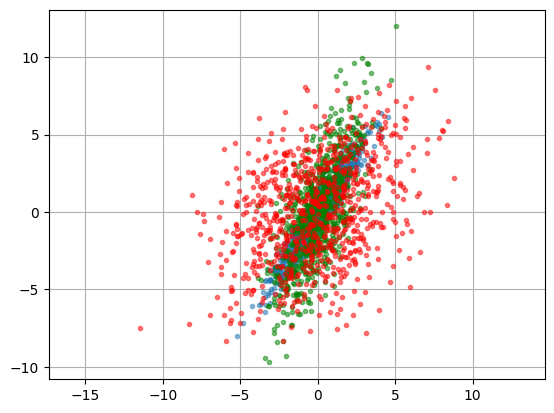

In [18]:
import numpy as np
import matplotlib.pyplot as plt

mean = np.array([0, 0])
cov = np.array([[2, 3], [3, 5]])
pts = np.random.multivariate_normal(mean, cov, size=800)

mean = np.array([0, 0])
cov = np.array([[2, 3], [3, 10]])
pts2 = np.random.multivariate_normal(mean, cov, size=800)

mean = np.array([0, 0])
cov = np.array([[10, 3], [3, 10]])
pts3 = np.random.multivariate_normal(mean, cov, size=800)


plt.plot(pts[:, 0], pts[:, 1], '.', alpha=0.5)
plt.plot(pts2[:, 0], pts2[:, 1], '.', color='green', alpha=0.5)
plt.plot(pts3[:, 0], pts3[:, 1], '.', color='red', alpha=0.5)
plt.axis('equal')
plt.grid()
plt.show()

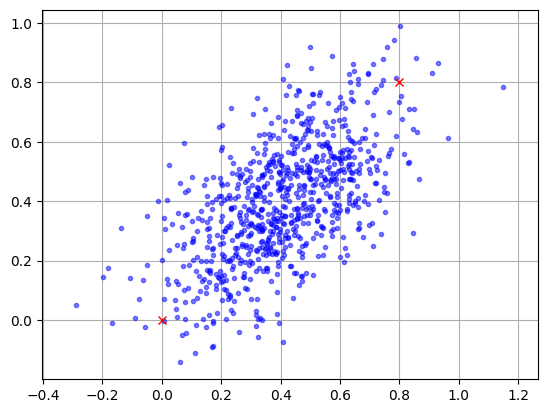

In [17]:
import torch
import matplotlib.pyplot as plt

def covariance_matrix(eigenvectors: torch.Tensor, eigenvalues: torch.Tensor) -> torch.Tensor:
    """
    Computes the covariance matrix from eigenvectors and eigenvalues
    Args:
    - eigenvectors: a tensor of shape (num_features, num_features) representing the eigenvectors
    - eigenvalues: a tensor of shape (num_features,) representing the eigenvalues
    Returns:
    - A tensor of shape (num_features, num_features) representing the covariance matrix
    """
    # check input shapes
    num_features = eigenvectors.shape[0]
    assert eigenvectors.shape == (num_features, num_features), "eigenvectors should be of shape (num_features, num_features)"
    assert eigenvalues.shape == (num_features,), "eigenvalues should be of shape (num_features,)"
    assert torch.abs(eigenvectors[0,:].dot(eigenvectors[1,:])) < 0.01, "not orthogonal basis"

    # normalize the eivenvectors and then scale according to the square roots of the eigenvectors 
    # see https://en.wikipedia.org/wiki/Covariance_matrix
    norm_eigenvectors = eigenvectors / eigenvectors.pow(2).sum(dim=1).sqrt().view(-1, 1)
    scaled_eigenvectors = eigenvalues.sqrt() * norm_eigenvectors

    # construct diagonal matrix from eigenvalues
    eigenvalues_matrix = torch.diag(eigenvalues)

    # compute covariance matrix using eigenvectors and eigenvalues
    covariance = scaled_eigenvectors @ eigenvalues_matrix @ scaled_eigenvectors.t()

    return covariance


def get_multivariate_normal_2d(centers: torch.Tensor) -> torch.distributions.multivariate_normal.MultivariateNormal:
    """ 
    Computes a multivariate normal from 2 NeRF centers.
    The sampling should have the highes chance at the mean of the centers.
    The covariance depends on the distance between the centers.
    Args:
    - centers: a tensor of shape (2, 2) representing the centers of the NeRFs
    Returns:
    - a MultivariateNormal for sampling positions accordingly.
    """
    assert centers.shape == (2, 2), "eigenvectors should be of shape (num_features, num_features)"

    mean = centers.mean(dim=0)

    direction = centers[0, :] - centers[1, :]
    direction_length = torch.linalg.vector_norm(direction, ord=2)
    direction_norm = direction / direction_length

    ortho_direction = torch.tensor([direction_norm[1], -direction_norm[0]], dtype=direction_norm.dtype, device=direction_norm.device)

    eigenvectors = torch.stack((direction_norm, ortho_direction), dim=0)
    eigenvalues = torch.tensor([torch.sqrt(direction_length/2)/3, torch.sqrt(direction_length/2)/3/2])
    
    sigma = direction_length / 2 / 2

    cov = covariance_matrix(eigenvectors, eigenvalues)

    return torch.distributions.multivariate_normal.MultivariateNormal(mean, covariance_matrix=cov)


# mean = torch.tensor([0, 0], dtype=torch.float)

# eigenvectors_1 = torch.tensor([[1, 1], [1, -1]], dtype=torch.float)
# #eigenvectors_2 = form_orthonormal_basis(torch.tensor([[1,1]], dtype=torch.float))
# eigenvalues_1 = torch.tensor([1, 2], dtype=torch.float)
# cov_1 = covariance_matrix(eigenvectors_1, eigenvalues_1)
# L, V = torch.linalg.eig(cov_1)
# cov_test = covariance_matrix(V, L)
# L2, V2 = torch.linalg.eig(cov_test)
# pts_1_np = np.random.multivariate_normal(mean, cov_1, size=800)
# mvn = torch.distributions.multivariate_normal.MultivariateNormal(mean, covariance_matrix=cov_1)
# pts_1 = mvn.rsample((800,))

nerf_centers = torch.tensor([[0,0], [0.8, 0.8]], dtype=torch.float)
mvn = get_multivariate_normal_2d(nerf_centers)
pts_1 = mvn.rsample((800, ))


plt.plot(pts_1[:, 0], pts_1[:, 1], '.', color='blue', alpha=0.5)
plt.plot(nerf_centers[:, 0], nerf_centers[:, 1], 'x', color='red', alpha=1.0)
plt.axis('equal')
plt.grid()
plt.show()

    